EfficientDet D0 모델과 D2모델 사용해서 가구 데이터 inference 수행

모델은 pretrained 된 모델을 tensorflow-hub를 통해 다운받아 사용

코드가 연구실 서버에서 실행시킨 것이기 때문에 수정이 필요할 경우 데이터 위치 확인 필요

In [1]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

TF Hub에서 EfficientDet d0 Inference 모델 다운로드 후 Inference 수행.
- 원하는 모델명은 TF Hub에서 검색해서 hub.lod()로 다운로드 후 tensorflow로 사용 가능할 수 있도록 로딩됨
- EfficientDet Tensorflow Object Detection API로 구현된 모델로 Download
- 로딩된 모델은 바로 원본 이미지로 Object Detection이 가능. 입력 값으로 numpy array, tensor 모두 가능하며 uint8로 구성 필요

In [2]:
#EfficientDetD0 512x512로 학습된 모델 다운
module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"
detector_model=hub.load(module_handle)

In [5]:
import cv2
import time
import numpy as np

In [7]:
img_array_np=cv2.imread('./100356.png')
img_array=img_array_np[np.newaxis,...] #모델에서 4차원을 기대하기 때문에 차원 추가
print(img_array_np.shape, img_array.shape)

(550, 550, 3) (1, 550, 550, 3)


In [8]:
start_time=time.time()
#image를 detector_model에 인자로 입력하여 inference 수행
result=detector_model(img_array)
print('elapsed time : ', time.time()-start_time)

elapsed time :  5.278168678283691


In [9]:
#np로 넣으니까 처음 실행시 시간이 조금 걸리는건가? 해서 tensor로 바꿔서 입력
img_tensor=tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[tf.newaxis,...]
start_time=time.time()
#image를 detector_model에 인자로 입력하여 inference 수행
result=detector_model(img_tensor)
print('elapsed time : ', time.time()-start_time)

elapsed time :  0.06414294242858887


In [10]:
#image를 numpy가 아니라 tensor로 로딩
def load_img(path):
    img=tf.io.read_file(path)
    #png파일일 경우 decode_png()호출
    img=tf.image.decode_jpeg(img, channels=3)
    print(img.shape, type(img))
    return img

In [12]:
import time

#image를 tensor형태로 로딩
img=load_img('./100356.png')
#3차원 image tensor를 4차원 tensor로 변환
#Efficientdet d0의 경우에는 입력 image를 uint8로 적용 필요
converted_img=tf.image.convert_image_dtype(img, tf.uint8)[tf.newaxis, ...]

start_time=time.time()
#image를 detector_model에 인자로 입력하여 inference 수행
result=detector_model(converted_img)
print('elapsed time : ', time.time()-start_time)

(550, 550, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
elapsed time :  0.061135292053222656


inference 수행 반환값 확인
- inference 결과는 dictionary 형태로 반환되며, 개별 key값은 Object Detection 모델에 따라 달라질 수 있음. 개별 value는 tensor로 되어 있음.
- inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며 ymin, xmin, ymax, xmax 형태로 반환되므로 반드시 주의 필요

In [ ]:
print(result.keys())
#detect 결과는 100개를 기본으로 Detect함
#(즉 Detect 된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위, num_detections는 100)
print(result['detection_boxes'].shape, result['detection_classes'].shape, result['detection_scores'].shape, result['num_detections'])

num_detections : 찾은 물체 갯수
detection_scores : 100개에 대한 confidence score, 객체가 bbox에 있는지 없는지에 대한 정확도

In [ ]:
#bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. y가 먼저, x가 나중에 나오므로 반드시 주의해야 함
#좌표 값은 원본 이미지의 width, height로 0-1 사이값으로 정규화됨
#나중에 해당 값을 원본 이미지 좌표값으로 바꾸기 위해서는 원본 이미지의 size를 곱하면 됨
print('#### detection_boxes #####')
print(result['detection_boxes'])

inference 결과를 이미지로 시각화

In [15]:
#result 내의 value들을 모두 numpy로 변환
result={key:value.numpy() for key, value in result.items()}

In [16]:
#1부터 91까지의 COCO Class id 매핑
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [17]:
def get_detector(module_handle="https://tfhub.dev/tensorflow/efficientdet/d0/1"):
    detector=hub.load(module_handle)
    return detector

detector_model=get_detector()

In [18]:
import os
from glob import glob

path = os.listdir('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장')
image_path=glob('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/*.png')
print(image_path[1])
print(type(image_path[0]))

/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/470145.png
<class 'str'>


/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/516981.png


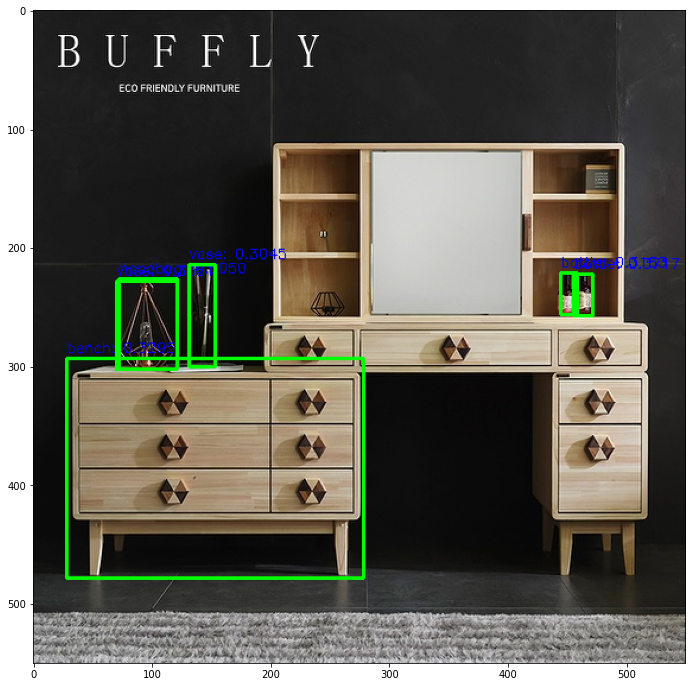

In [19]:
import cv2
from glob import glob

image_path=glob('/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/*.png')
img_array=cv2.cvtColor(cv2.imread(image_path[0]), cv2.COLOR_BGR2RGB)

#scaling된 이미지 기반으로 bounding box위치가 예측 되므로
#이를 다시 원복하기 위해 원본 이미지 shape 정보 필요
#bbox가 0에서 1사이 값으로 정규화되서 나오기 때문에 다시 곱해야 원본에서의 위치 정보를 알 수 있다
height=img_array.shape[0]
width=img_array.shape[1]
#cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로
#그림 표현을 위한 별도의 이미지 배열 생성
draw_img=img_array.copy()

#bounding bos의 테두리와 caption글자색 지정
green_color=(0, 255, 0)
red_color=(0,0,255)

#cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor=tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
#img_tensor=tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxiz, ...]

#pretrained 모델을 다운로드 한 뒤 inference 수행
result=detector_model(img_tensor)
#reuslt 내부의 value를 numpy로 변환
result={key:value.numpy() for key, value in result.items()}

SCORE_THRESHOLD=0.3
OBJECT_DEFAULT_COUNT=100

#detected 된 object들을 iteration하면서 정보 추출
#detect된 object의 갯수는 100개
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
    #detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop중단.
    score=result['detection_scores'][0,i]
    if score<SCORE_THRESHOLD:
        break
    box=result['detection_boxes'][0,i]

    xmin = box[1]*width
    ymin = box[0]*height
    xmax = box[3]*width
    ymax = box[2]*height

    class_id=result['detection_classes'][0,i]
    caption="{}: {:.4f}".format(labels_to_names[class_id],score)
    #cv2.rectangel()은 인자로 들어온 draw_img에 사각형을 그리는 함수. 위치 인자는 반드시 정수형
    cv2.rectangle(draw_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(xmin), int(ymin-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)
print(image_path[0])

In [20]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):   
  # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
  height = img_array.shape[0]
  width = img_array.shape[1]
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # efficientdet모델로 inference 수행. 
  start_time = time.time()
  # inference 결과로 내부 원소가 Tensor이 Dict 반환 
  result = model(img_tensor)
  # result 내부의 value를 numpy 로 변환. 
  result = {key:value.numpy() for key,value in result.items()}

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    # class id 추출하고 class 명으로 매핑
    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

handbag: 0.5050
Detection 수행시간: 0.07 초


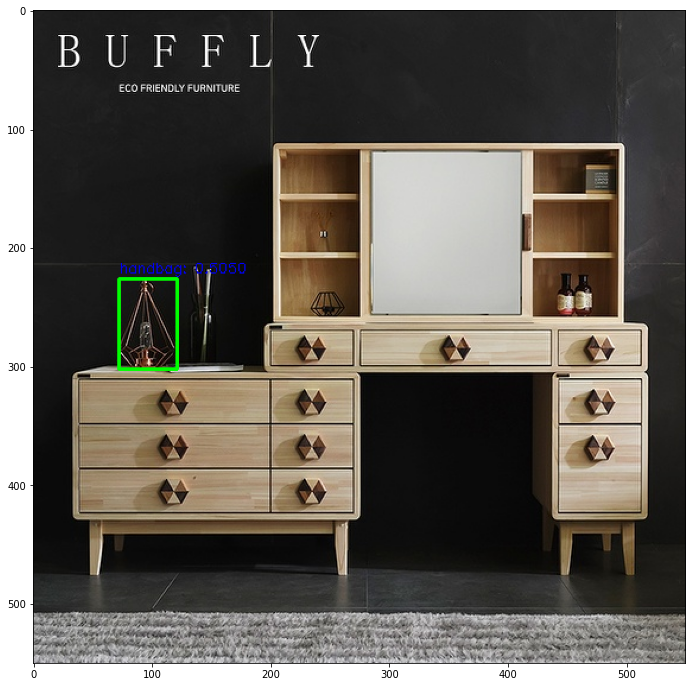

In [21]:
img_array = cv2.cvtColor(cv2.imread(image_path[0]), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)



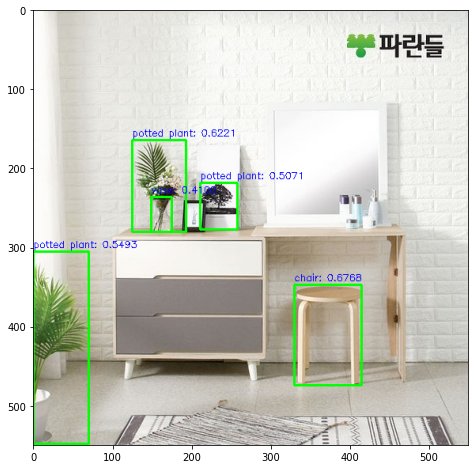

In [23]:
plt.figure(figsize=(12, 8))
plt.imshow(draw_img)
#score_threshold 값을 0.4로 했더니 박스 하나만 출력

/home/plass-heesu/KimHeeSu/munsu/Hanssem/Hanssem_data/수납장/470145.png
chair: 0.6768
potted plant: 0.6221
potted plant: 0.5493
potted plant: 0.5071
vase: 0.4100
Detection 수행시간: 0.06 초


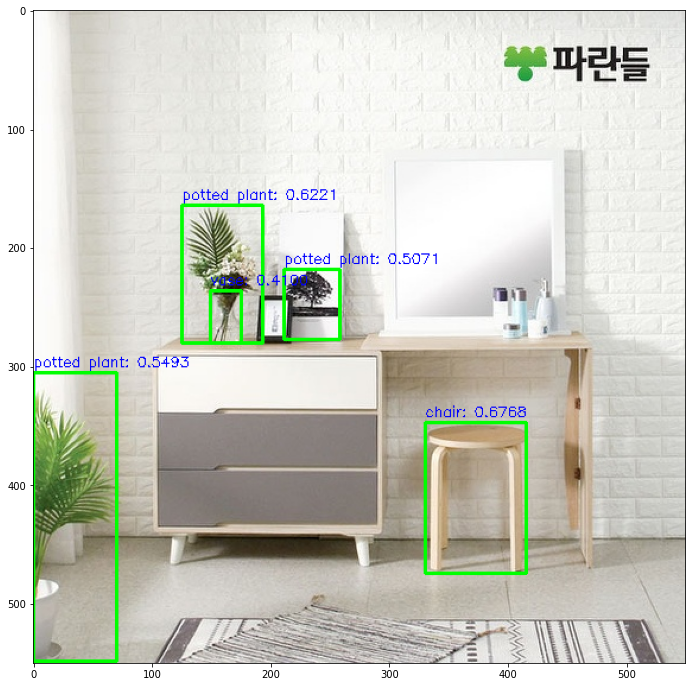

In [22]:
print(image_path[1])
img_array=cv2.cvtColor(cv2.imread(image_path[1]), cv2.COLOR_BGR2RGB)
draw_img=get_detected_img(detector_model, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)

EfficientDet D2모델로 inference 수행

In [ ]:
detector_model_d2=get_detector('https://tfhub.dev/tensorflow/efficientdet/d2/1')

In [ ]:
print(image_path[0])
img_array=cv2.cvtColor(cv2.imread(image_path[0]), cv2.COLOR_BGR2RGB)
draw_img=get_detected_img(detector_model_d2, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)

In [ ]:
print(image_path[1])
img_array=cv2.cvtColor(cv2.imread(image_path[1]), cv2.COLOR_BGR2RGB)
draw_img=get_detected_img(detector_model_d2, img_array, score_threshold=0.4, object_show_count=100, is_print=True)

plt.figure(figsize=(12,12))
plt.imshow(draw_img)